In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils


In [2]:
#GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [76]:

def load_test_img(image_path, y_train=None):
    images = []
    for filename in os.listdir(image_path):
        if filename.endswith(".png") is False:
            continue
        print(filename)
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, binary_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            binary_image = binary_image.astype(np.uint8)  # 이미지 형식 변환
            distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
            img = cv2.resize(distance_transform, (32, 32)) # 이미지 크기 조정
            img = img.astype(np.float32) / 255.0
            images.append(img)
    return np.array(images)



In [77]:
test_imgs = load_test_img("./flask/input_imgs")

flipped_sf000000.png
sf_input.png


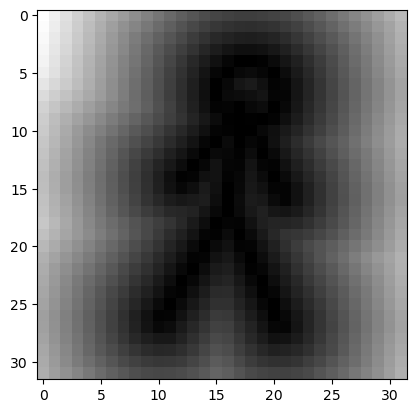

In [80]:
import matplotlib.pyplot as plt

plt.imshow(np.array(test_imgs[0]).reshape(32, 32, -1), cmap='gray')
plt.show()

In [58]:
# a cnn sequential model by pytorch
class SK_CNN(nn.Module):

    def __init__(self):
        super(SK_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 22)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [59]:
SAVE_DIR = './model_save'

model = SK_CNN()
model.load_state_dict(torch.load(SAVE_DIR + '/trained_model.pt'))

<All keys matched successfully>

In [82]:


x_ex_preprocessed = test_imgs.reshape(-1, 1, 32, 32)/255.0
# transpose 
x_ex_preprocessed = x_ex_preprocessed.transpose(0, 1, 3, 2)

# X_ex_image = cv2.imread("./flask/input_imgs/sf_input.png")
X_ex_image = cv2.imread("./flask/input_imgs/flipped_sf000000.png")

# 각 관절 위치 값 저장
# data=predictions[0]
data=model(torch.tensor(x_ex_preprocessed))[0].detach().numpy()
data = data*320
print(data)
c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(X_ex_image,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(X_ex_image,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(X_ex_image,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(X_ex_image,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(X_ex_image,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(X_ex_image,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(X_ex_image,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(X_ex_image,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(X_ex_image,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(X_ex_image,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(X_ex_image,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


# 각 연결을 나타내는 튜플 리스트
connections = [(c1_x, c1_y, c2_x, c2_y),
               (c2_x, c2_y, c3_x, c3_y),
               (c2_x, c2_y, le_x, le_y),
               (c2_x, c2_y, re_x, re_y),
               (le_x, le_y, lh_x, lh_y),
               (re_x, re_y, rh_x, rh_y),
               (c1_x, c1_y, lk_x, lk_y),
               (c1_x, c1_y, rk_x, rk_y),
               (lk_x, lk_y, lf_x, lf_y),
               (rk_x, rk_y, rf_x, rf_y)]

# 주황색 RGB 값
orange = (255, 165, 0)

# 각 연결에 대해 선을 그립니다
for conn in connections:
    cv2.line(X_ex_image, (conn[0], conn[1]), (conn[2], conn[3]), orange, thickness=2)

# 색상 공간을 RGB로 변환하고 이미지를 출력합니다
# img = cv2.cvtColor(X_ex_image, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
plt.imshow(X_ex_image)
plt.show()



ValueError: axes don't match array